In [1]:
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt 
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

In [23]:
resize = 224     #  重设大小
total_num = 200   
train_num = 160
epochs = 3      #训练轮次
batch_size = 4

In [24]:
dir_data = 'D:/文档类/机器学习课设/mask_classify/train'   #  数据路径
dir_mask = os.path.join(dir_data, 'with_mask')   
dir_nomask = os.path.join(dir_data, 'without_mask')

assert os.path.exists(dir_mask), 'Could not find ' + dir_mask#确认路径是否存在
assert os.path.exists(dir_nomask), 'Could not find ' + dir_nomask

fpath_mask = [os.path.abspath(fp) for fp in glob.glob(os.path.join(dir_mask, '*.jpg'))]
fpath_nomask = [os.path.abspath(fp) for fp in glob.glob(os.path.join(dir_nomask, '*.jpg'))]

num_mask = len(fpath_mask) # 样本量
num_nomask = len(fpath_nomask)

label_mask = [0] * num_mask  # 标签
label_nomask = [1] * num_nomask

print('#mask:   ', num_mask)
print('#nomask: ', num_nomask)

RATIO_TEST = 0.1 # 测试样本比列

num_mask_test = int(num_mask * RATIO_TEST)
num_nomask_test = int(num_nomask * RATIO_TEST)

# train
fpath_train = fpath_mask[num_mask_test:] + fpath_nomask[num_nomask_test:]#训练样本
label_train = label_mask[num_mask_test:] + label_nomask[num_nomask_test:]
# test
fpath_test = fpath_mask[:num_mask_test] + fpath_nomask[:num_nomask_test]#测试样本
label_test = label_mask[:num_mask_test] + label_nomask[:num_nomask_test]

num_train = len(fpath_train)
num_test = len(fpath_test)

print(num_train)
print(num_test)

def preproc(fpath, label): # 读取图片,归一化处理
    image_byte = tf.io.read_file(fpath)
    image = tf.io.decode_image(image_byte)
    image_resize = tf.image.resize_with_pad(image, 224, 224)
    image_norm = tf.cast(image_resize, tf.float32) / 255.
    
    label_onehot = tf.one_hot(label, 2)         #将input转化为one-hot类型数据输出
    
    return image_norm, label_onehot

#数据预处理
dataset_train = tf.data.Dataset.from_tensor_slices((fpath_train, label_train)) 
dataset_train = dataset_train.shuffle(num_train).repeat()#随机排序样本
dataset_train = dataset_train.map(preproc, num_parallel_calls=tf.data.experimental.AUTOTUNE)#读取样本图片,归一化处理
dataset_train = dataset_train.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)#抓取一定量的样本图片进行预读取,然后调度样本

dataset_test = tf.data.Dataset.from_tensor_slices((fpath_test, label_test))
dataset_test = dataset_test.shuffle(num_test).repeat()
dataset_test = dataset_test.map(preproc, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_test = dataset_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


#mask:    2544
#nomask:  2544
4580
508


In [25]:
model = keras.Sequential(name='Alexnet')   # 搭建模型(五层卷积层,三层全连接层)


model.add(layers.Conv2D(filters=96, kernel_size=(11,11),
                 strides=(4,4), padding='valid',
                 input_shape=(resize,resize,3),
                 activation='relu'))             
#卷积层,功能是对输入数据进行特征提取，其内部包含多个卷积核，组成卷积核的每个元素都对应一个权重系数和一个偏差量

model.add(layers.BatchNormalization())
#批量标准化层,其应用了一种转换，使得数据的均值趋于0，标准差趋于1。

model.add(layers.MaxPooling2D(pool_size=(3,3), 
                       strides=(2,2), 
                       padding='valid'))
#池化层,功能是对输入的特征图进行压缩，一方面使特征图变小，简化网络计算复杂度；一方面进行特征压缩，提取主要特征。

model.add(layers.Conv2D(filters=256, kernel_size=(5,5), 
                 strides=(1,1), padding='same', 
                 activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(3,3), 
                       strides=(2,2), 
                       padding='valid'))

model.add(layers.Conv2D(filters=384, kernel_size=(3,3), 
                 strides=(1,1), padding='same', 
                 activation='relu'))
model.add(layers.Conv2D(filters=384, kernel_size=(3,3), 
                 strides=(1,1), padding='same', 
                 activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(3,3), 
                 strides=(1,1), padding='same', 
                 activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), 
                       strides=(2,2), padding='valid'))

model.add(layers.Flatten())
#Flatten层,功能是将输入“压平”，即把多维的输入一维化
model.add(layers.Dense(4096, activation='relu'))
#全连接层（Dense）,在整个卷积神经网络中起到”分类器”作用,起到”将学到的分布式特征表示”映射到样本标记空间的作用。
model.add(layers.Dropout(0.5))
#Dropout层,功能是在标准的bp网络的的结构上，使bp网的隐层激活值，以一定的比例v变为0，即按照一定比例v，随机地让一部分隐层节点失效。

model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(2, activation='softmax'))

# Training
model.compile(loss='categorical_crossentropy', # loss
              optimizer='sgd',
              metrics=['accuracy'])


history = model.fit(dataset_train,
          steps_per_epoch = num_train//batch_size,
          epochs = epochs,
          validation_data = dataset_test,
          validation_steps = num_test//batch_size,
          verbose = 1)                      #verbose是日志显示,值为1,显示进度条


# scores = model.evaluate(train_data, train_label, verbose=1)
scores = model.evaluate(dataset_train, steps=num_train//batch_size, verbose=1)
print(scores)

# scores = model.evaluate(test_data, test_label, verbose=1)
scores = model.evaluate(dataset_test, steps=num_test//batch_size, verbose=1)
print(scores)

model.save('D:/model/mask_model_2.h5') 

# Record loss and acc
history_dict = history.history
train_loss = history_dict['loss']
train_accuracy = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_accuracy = history_dict['val_accuracy']


Epoch 1/3
1145/1145 [==============================] - 231s 201ms/step - loss: 0.3980 - accuracy: 0.8275 - val_loss: 0.3479 - val_accuracy: 0.8150
Epoch 2/3
1145/1145 [==============================] - 228s 199ms/step - loss: 0.2235 - accuracy: 0.9162 - val_loss: 0.2730 - val_accuracy: 0.8642
Epoch 3/3
1145/1145 [==============================] - 35s 31ms/step - loss: 0.1637 - accuracy: 0.9343
[0.16372862458229065, 0.9342795014381409]
127/127 [==============================] - 4s 32ms/step - loss: 0.2205 - accuracy: 0.9134
[0.2205280065536499, 0.913385808467865]


C:\Users\86173\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
import pandas as pd
import matplotlib.pyplot as plt 
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.398002,0.827511,0.347888,0.814961,0
1,0.223520,0.916157,0.272956,0.864173,1
2,0.191056,0.929913,0.220528,0.913386,2


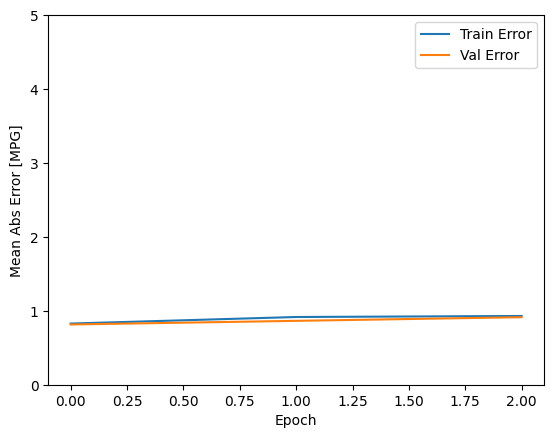

In [27]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()


  plt.show()


plot_history(history)                                                                                          


In [32]:
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
resize = 224
label = ('带口罩!', '没戴口罩了')
image = cv2.resize(cv2.imread(                                                                                                                                                                                                                                                                                                                                                                    work/4.jpg'),(resize,resize))
image = image.astype("float") / 255.0
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

predict = model.predict(image)
i = predict.argmax(axis=1)[0]
print(label[i])



1/1 [==============================] - 0s 27ms/step
没戴口罩了
